# "I need a vacation, but where should I go?"

## Import Libraries

In [2]:
# General libraries
import numpy as np
import pandas as pd
import seaborn as sns
import random

# Data lists for scraping
from project4data import cities, countries
from webscrape import country

# Scraping
import os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys 
import time
import requests
from bs4 import BeautifulSoup

# MongoDB
from pymongo import MongoClient

# NLP cleaning
#from cleaning import clean_article

# Vectorising
import copy 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Topic Modelling & Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

# PCA
from sklearn.decomposition import PCA

# Recommender Engine
from recommender import recommendation,return_countries

FileNotFoundError: [Errno 2] No such file or directory: '../ranked_df.pickle'

---

## Put data into MongoDB

In [11]:
# Import the required libraries
import os

# Define the location of the directory
path =r""

articles = []
# Change the directory
os.chdir(path)

def read_files(file_path):
   with open(file_path, 'r') as file:
      articles.append(file.read())

# Iterate over all the files in the directory
for file in os.listdir():
   if file.endswith('.txt'):
      # Create the filepath of particular file
      file_path =f"{path}/{file}"
      read_files(file_path)

In [13]:
# Create dictionary for each: _id, City, Country, Article
mongo_list = []
for i in range(len(articles)):
    mongo_list.append({'_id': i+1, 'City':cities[i], 'Country': countries[i], 'Article': articles[i]})

In [14]:
# Create and add full article data into MongoDB
client = MongoClient()
db = client['']
collection = db['']
collection.insert_many(mongo_list)


In [15]:
# Test
cursor = list(db.travel_articles.find({'_id': 1}, {'_id':1, 'City':1, 'Article':1}))
cursor

[{'_id': 1,
  'City': 'Amsterdam',
  'Article': "BELIEVE it or not, there are far more intoxicating reasons to visit Amsterdam these days than its infamous coffee shops or its red-light district. Not since the Dutch Golden Age has Amsterdam seen such a creative boom. All along the harbor and in the city's South Axis area, futuristic buildings designed by architects like Renzo Piano and Rafael Viñoly have been going up — a modernist foil to the city's venerable canal houses. The country known for Rembrandt and Franz Hals also has modern day counterparts in Amsterdam design stars like Marcel Wanders and Tord Boontje. And the restaurant scene is finally catching up with the rest of Europe. Amsterdam is angling to become Europe's creative capital, and it's doing so without even inhaling.\n\nFriday\n\n4:30 p.m.\n1) GET SOME WHEELS\n\nFirst things first. Renting a bike is key in Amsterdam; you can avoid expensive taxi rides and feel like a local from the start. Don't be nervous. Two-wheels r

---

## Clean text data

In [16]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from unicodedata import normalize, category
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer


In [17]:
def clean_article(article):

    # Find all proper nouns and names in article - keep to one side
    nouns_list = []
    for tup in pos_tag(word_tokenize(article)):
        if 'NNP' in tup:
            nouns_list.append(tup[0].lower())

    # Remove accents (keep as just letters)
    article = ''.join([c for c in normalize('NFD',article.lower()) if category(c) != 'Mn'])
    article = re.sub(r'[-|—|’|“|”|£]', ' ', article)
    article = re.sub('\(.*?\)', '', article)

    # Tokenize article in words
    tokens = nltk.word_tokenize(article)

    # Remove all punctuation & numbers
    for idx, word in enumerate(tokens):
        tokens[idx] = "".join(l for l in word if l not in string.punctuation)

    for idx, word in enumerate(tokens):
        if re.compile('\w*\d\w*').match(word):
            tokens[idx] = ''

    # Remove stopwords
    stops = list(stopwords.words('english'))

    for idx, word in enumerate(tokens):
        if word in stops:
            tokens[idx] = ''

    # Remove 'credit' from words
    for idx, word in enumerate(tokens):
        if "credit" in word:
            tokens[idx] = ''
        if "euro" in word:
            tokens[idx] = ''
        if "city" in word:
            tokens[idx] = ''

    # Remove spaces and 2 letter words and words over 15 letters
    final_list = []
    for word in tokens:
        if 2<len(word)<15:
            final_list.append(word)

    # Remove nouns and names
    total_list = []
    for word in final_list:
        if word not in nouns_list:
            total_list.append(word)

    # Lemmatize words & stem
    for idx, word in enumerate(total_list):
        new_word = WordNetLemmatizer().lemmatize(word, pos='v')
        new_word = LancasterStemmer().stem(new_word)
        total_list[idx] = new_word


    return ' '.join(total_list)


In [18]:
# Clean all articles from scraped data
clean_articles = []

for city_id in range(1,14):
    art = list(db.travel_articles.find({'_id': city_id}, {'_id':0, 'Article':1}))
    for obj in art:
        clean_articles.append(clean_article(str(obj['Article']))) 

---

## Count Vectorize

In [19]:
# Make a copy of the articles for count vectorising & tfidf
cv_articles = copy.deepcopy(clean_articles) 
tf_articles = copy.deepcopy(clean_articles)

In [20]:
cv = CountVectorizer(min_df=0.15, max_df=0.9)
cv_X = cv.fit_transform(cv_articles)

In [21]:
cv_array = pd.DataFrame(cv_X.toarray(), index=cities, columns=cv.get_feature_names())

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
cv_array.head()

,abund,acc,access,accommod,accompany,account,acr,across,act,ad,...,workshop,world,worthy,would,writ,year,yet,yog,young,zigz
Amsterdam,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
Bali,1,0,1,1,0,0,0,0,1,0,...,1,0,0,2,0,1,1,1,0,0
Bangalore,0,0,0,0,0,1,1,2,1,0,...,0,0,0,0,0,1,0,0,1,0
Bangkok,0,0,0,0,0,0,1,3,0,0,...,0,0,0,0,0,2,0,0,0,0
Barcelona,0,0,0,0,2,0,0,1,0,0,...,0,1,0,0,2,0,0,0,0,0


---

## TF-IDF

In [23]:
tfidf = TfidfVectorizer(min_df=0.1, max_df=0.9, ngram_range=(1,3))
tf_X = tfidf.fit_transform(tf_articles)

In [24]:
tf_array = pd.DataFrame(tf_X.toarray(), index=cities, columns=tfidf.get_feature_names())

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
tf_array.head()

,abund,acc,access,accommod,accompany,account,account sav,account sav map,acr,across,...,worthy,would,writ,year,year ago,year old,yet,yog,young,zigz
Amsterdam,0.00000,0.0,0.031353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026699,...,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.041715,0.0
Bali,0.04087,0.0,0.027239,0.036242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.08174,0.000000,0.018568,0.0,0.0,0.036242,0.04087,0.000000,0.0
Bangalore,0.00000,0.0,0.000000,0.000000,0.000000,0.038536,0.043457,0.043457,0.034719,0.049329,...,0.0,0.00000,0.000000,0.019743,0.0,0.0,0.000000,0.00000,0.038536,0.0
Bangkok,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032644,0.069570,...,0.0,0.00000,0.000000,0.037126,0.0,0.0,0.000000,0.00000,0.000000,0.0
Barcelona,0.00000,0.0,0.000000,0.000000,0.091812,0.000000,0.000000,0.000000,0.000000,0.026054,...,0.0,0.00000,0.091812,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0


---

## Topic Modelling

### LSA and TFIDF

In [50]:
tf_array.shape

(13, 1452)

In [26]:
lsa = TruncatedSVD(5) 
doc_topic = lsa.fit_transform(tf_array) 
lsa.explained_variance_ratio_.round(3)

array([0.   , 0.107, 0.101, 0.093, 0.089])

In [27]:
# Create dataframe of each word and weighting of word per article
topic_word = pd.DataFrame(lsa.components_.round(3),
             columns = tfidf.get_feature_names())
topic_word

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abund,acc,access,accommod,accompany,account,account sav,account sav map,acr,across,...,worthy,would,writ,year,year ago,year old,yet,yog,young,zigz
0,0.011,0.012,0.032,0.016,0.018,0.016,0.012,0.012,0.019,0.044,...,0.021,0.022,0.018,0.067,0.017,0.011,0.015,0.011,0.022,0.012
1,-0.002,-0.004,-0.008,0.011,-0.021,0.005,0.023,0.023,-0.002,-0.027,...,-0.022,0.040,-0.021,0.041,0.034,-0.000,0.013,0.022,-0.028,0.009
2,0.022,-0.020,0.002,-0.015,-0.036,0.006,-0.009,-0.009,0.022,0.022,...,-0.012,-0.007,-0.036,0.021,0.034,0.008,-0.013,0.022,0.015,-0.010
3,-0.001,0.010,-0.019,0.003,0.010,-0.035,-0.029,-0.029,-0.010,-0.059,...,-0.054,0.027,0.010,-0.039,0.011,-0.012,-0.020,0.017,-0.027,0.001
4,0.019,0.015,0.017,0.001,-0.033,-0.018,-0.024,-0.024,-0.029,-0.014,...,0.017,0.080,-0.033,0.032,-0.019,-0.001,0.018,0.005,-0.011,-0.009


In [28]:
# Function to show most important words in different topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    
    '''Displays topics and word in order of importance for each topic
    Inputs: Model being used for analysis, topic names, number of words to 
    present for each category'''
    
    for idx, topic in enumerate(model.components_):
        if not topic_names or not topic_names[idx]:
            print("\nTopic ", idx)
        else:
            print("\nTopic: '",topic_names[idx],"'")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [29]:
display_topics(lsa, tfidf.get_feature_names(),15)


Topic  0
bar, loc, two, tour, win, night, start, spac, serv, off, includ, get, around, plac, rup

Topic  1
rup, im, col, per, plac, vil, germ, decad, around rup, brunch, serv, beach, import, coconut, vib

Topic  2
glow, whit, window, serv, soar, templ, gold, smal, wal, hotel, food, amid, green, soft, bel

Topic  3
tour, rat, lin, stil, sint, view, vil, crowd, rol, rid, start, district, get, are, spring

Topic  4
germ, er, form, per night, stil, night, preserv, apart, coff, would, cloth, sens, swa, list, smal


c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
# Create dataframe of topic array (Vt in equation)
Vt = pd.DataFrame(doc_topic.round(5),
             index = cities)
Vt.head()

,0,1,2,3,4
Amsterdam,0.58047,-0.27604,-0.34965,0.11991,0.02722
Bali,0.51132,0.33861,0.13021,0.18364,0.29464
Bangalore,0.53958,0.32685,0.05675,-0.35526,-0.39994
Bangkok,0.53015,-0.34342,0.42785,-0.16519,0.10012
Barcelona,0.53848,-0.14419,-0.27519,0.28201,-0.37409


In [31]:
# Check similarity between articles
cos_sim = pd.DataFrame(cosine_similarity(Vt).round(), index=cities, columns=cities)
cos_sim.head()

,Amsterdam,Bali,Bangalore,Bangkok,Barcelona,Berlin,Boston,Budapest,Cape Town,Dubai,Goa,Hong Kong,Jaipur
Amsterdam,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
Bali,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
Bangalore,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
Bangkok,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
Barcelona,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


**Observations**:
- A lot of similarity between a lot of cities - possibly due to the way each article is structured?

### NMF and TFIDF - [Best]

In [32]:
nmf_model = NMF(6, random_state=27) # Try dfferent topic numbers 
doc_topic_nmf_tfidf = nmf_model.fit_transform(tf_array)

In [33]:
topic_word = pd.DataFrame(nmf_model.components_.round(3), #.components_ gets it out of NMF              
             columns =tfidf.get_feature_names())
topic_word

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abund,acc,access,accommod,accompany,account,account sav,account sav map,acr,across,...,worthy,would,writ,year,year ago,year old,yet,yog,young,zigz
0,0.000,0.033,0.043,0.038,0.078,0.003,0.005,0.005,0.024,0.033,...,0.003,0.000,0.078,0.017,0.000,0.000,0.004,0.000,0.028,0.034
1,0.000,0.000,0.034,0.016,0.000,0.046,0.054,0.054,0.037,0.056,...,0.016,0.000,0.000,0.126,0.065,0.017,0.017,0.016,0.023,0.029
2,0.029,0.000,0.035,0.000,0.000,0.023,0.000,0.000,0.028,0.067,...,0.025,0.000,0.000,0.062,0.014,0.008,0.000,0.007,0.050,0.000
3,0.000,0.000,0.031,0.000,0.044,0.001,0.000,0.000,0.000,0.077,...,0.081,0.000,0.044,0.062,0.000,0.045,0.041,0.000,0.002,0.000
4,0.000,0.038,0.000,0.001,0.000,0.000,0.001,0.001,0.000,0.000,...,0.002,0.078,0.000,0.055,0.001,0.000,0.002,0.000,0.000,0.000
5,0.043,0.000,0.029,0.038,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.088,0.000,0.022,0.000,0.000,0.039,0.044,0.000,0.000


In [34]:
display_topics(nmf_model, tfidf.get_feature_names(), 15)


Topic  0
loc, spac, bar, cours, feat, start, two, bik, eleg, three, win, tour, crowd, town, design

Topic  1
rup, might, col, im, serv, around, ev, century, weekend, dom, beach, year, around rup, day, origin

Topic  2
glow, whit, soar, bar, gold, gallery, bel, window, templ, brit, cool, high, vint, smal, food

Topic  3
list, therm, many, atmosph, origin, pork, jew, pub, whiskey, sev, cuisin, brand, neighb, star, modern

Topic  4
germ, form, er, sens, preserv, cloth, two, apart, stil, swa, flo, night, coff, three, tour

Topic  5
plac, ric, vil, coconut, smal, mass, stil, bargain, swim, found, carv, milk, less, los, pric


c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [35]:
# Create dictionary of City and most prominent topic
city_topic_nmf_tfidf = dict(zip(cities, np.argmax(doc_topic_nmf_tfidf, axis=1)))

In [36]:
# Check each topic to observe cities
for number in range(0,7):
    for k,v in city_topic_nmf_tfidf.items():
        if v == number:
            print(f"Topic: {number}, {k}")

Topic: 0, Amsterdam
Topic: 0, Barcelona
Topic: 0, Boston
Topic: 1, Bangalore
Topic: 1, Cape Town
Topic: 1, Goa
Topic: 1, Jaipur
Topic: 2, Bangkok
Topic: 2, Dubai
Topic: 2, Hong Kong
Topic: 3, Budapest
Topic: 4, Berlin
Topic: 5, Bali


In [37]:
# Check prevelance of topic for each city
H = pd.DataFrame(doc_topic_nmf_tfidf.round(5),
             index = cities)
H.head(5)

,0,1,2,3,4,5
Amsterdam,0.36155,0.00000,0.00000,0.02354,0.06639,0.0000
Bali,0.00000,0.00000,0.00000,0.00000,0.00000,0.9149
Bangalore,0.00000,0.48915,0.00000,0.00000,0.00000,0.0000
Bangkok,0.00000,0.00000,0.61695,0.00000,0.00000,0.0000
Barcelona,0.37963,0.00000,0.00000,0.00000,0.00000,0.0018


In [38]:
cos_sim_nmf = pd.DataFrame(cosine_similarity(H).round(), index=cities, columns=cities)
cos_sim_nmf.head()

,Amsterdam,Bali,Bangalore,Bangkok,Barcelona,Berlin,Boston,Budapest,Cape Town,Dubai,Goa,Hong Kong,Jaipur
Amsterdam,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
Bali,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bangalore,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
Bangkok,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
Barcelona,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


- NMF gives better categories and splits the cities into better topics than LSA

### NMF and CountVectoriser

In [39]:
nmf_model = NMF(6, random_state=27)
doc_topic = nmf_model.fit_transform(cv_array)

c:\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [40]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),              
             columns =cv.get_feature_names())
topic_word

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abund,acc,access,accommod,accompany,account,acr,across,act,ad,...,workshop,world,worthy,would,writ,year,yet,yog,young,zigz
0,0.000,0.789,1.351,1.102,1.205,0.337,0.881,0.998,0.185,0.000,...,0.000,0.705,0.141,0.000,1.205,0.570,0.085,0.000,0.834,0.837
1,0.698,0.000,1.316,0.000,0.000,0.678,0.826,3.177,1.353,0.000,...,0.000,0.021,0.629,0.000,0.000,3.015,0.000,0.000,1.368,0.000
2,0.000,0.000,3.172,0.000,3.094,0.826,0.239,10.707,4.009,3.214,...,0.000,6.433,6.990,0.000,3.094,10.436,3.331,0.000,0.731,0.000
3,0.665,0.000,1.610,0.781,0.000,0.418,0.109,0.691,1.005,0.395,...,0.505,0.000,0.000,1.269,0.000,3.741,0.757,0.589,0.181,0.509
4,0.000,0.000,0.000,0.000,0.000,0.044,0.591,0.621,0.000,0.534,...,1.053,0.064,0.000,0.000,0.000,1.645,0.000,0.509,0.041,0.000
5,0.000,0.266,0.000,0.012,0.000,0.031,0.000,0.000,0.024,0.000,...,0.000,0.000,0.029,0.551,0.000,0.910,0.027,0.000,0.014,0.000


In [41]:
display_topics(nmf_model, cv.get_feature_names(), 15)


Topic  0
loc, bar, spac, two, feat, includ, start, win, design, tour, also, cours, three, din, stop

Topic  1
bar, whit, gallery, tradit, food, glow, wood, soar, light, spac, two, class, bel, vint, air

Topic  2
many, list, loc, origin, lat, off, neighb, star, bout, win, modern, glass, atmosph, sev, cuisin

Topic  3
plac, century, beach, ev, lov, coconut, two, day, im, lif, vil, art, ric, mass, year

Topic  4
tour, serv, wal, around, back, courtyard, gard, near, ceil, hotel, window, get, walk, jewelry, flo

Topic  5
form, germ, two, flo, er, loc, night, apart, three, stil, tour, win, cloth, caf, build


c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:
city_topic = dict(zip(cities, np.argmax(doc_topic, axis=1)))

In [44]:
# Check each topic to observe cities
for number in range(0,7):
    for k,v in city_topic.items():
        if v == number:
            print(f"Topic: {number}, {k}")

Topic: 0, Barcelona
Topic: 0, Boston
Topic: 1, Bangkok
Topic: 1, Dubai
Topic: 2, Budapest
Topic: 3, Bali
Topic: 3, Bangalore
Topic: 3, Goa
Topic: 4, Hong Kong
Topic: 4, Jaipur
Topic: 5, Amsterdam
Topic: 5, Berlin
Topic: 5, Cape Town


In [45]:
H2 = pd.DataFrame(doc_topic.round(5),
             index = cities)
H2.head()

,0,1,2,3,4,5
Amsterdam,0.37112,0.00000,0.01354,0.00000,0.00000,0.38603
Bali,0.00000,0.00000,0.00000,0.73965,0.00000,0.00000
Bangalore,0.05632,0.00062,0.05241,0.31095,0.27229,0.00000
Bangkok,0.00000,0.68641,0.00000,0.00000,0.00000,0.00000
Barcelona,0.32316,0.00000,0.00005,0.07965,0.06349,0.00000


In [46]:
# Cosine similarity between all cities
cos_sim_nmf = pd.DataFrame(cosine_similarity(H).round(), columns=cities, index=cities)
cos_sim_nmf.head(10)

,Amsterdam,Bali,Bangalore,Bangkok,Barcelona,Berlin,Boston,Budapest,Cape Town,Dubai,Goa,Hong Kong,Jaipur
Amsterdam,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
Bali,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bangalore,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
Bangkok,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
Barcelona,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Berlin,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Boston,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Budapest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Cape Town,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
Dubai,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


**Observations:**
- More change in cosine similarity - all seem to be either 0 or 1.

### PCA - Reduce 6 topics to 2 for demonstration

- Best topics came from using TFIDF and NMF - use for demonstration and recommender engine

In [47]:
# normalise numbers across df
norm_df = H.div(H.sum(axis=1), axis=0)

In [48]:
# Run PCA to reduce to 2 components
pca = PCA(n_components=2)
pca.fit(norm_df)
pcafeatures = pca.transform(norm_df)

In [49]:
# Create df
pca_df = pd.DataFrame(pcafeatures, index=cities)

# Add topic and countries column 
pca_df['Topics'] = list(np.argmax(doc_topic_nmf_tfidf, axis=1))
pca_df['Countries'] = countries
pca_df.head()

,0,1,Topics,Countries
Amsterdam,0.629722,-0.102486,0,The Netherlands
Bali,-0.034958,0.063002,5,Indonesia
Bangalore,-0.540057,-0.601952,1,India
Bangkok,-0.288668,0.786218,2,Thailand
Barcelona,0.786744,-0.123356,0,Spain


In [50]:
# Save for Tableau dashboard
pca_df.to_csv('twodim2.csv', index=True)

In [51]:
topic_list=['Walking/Tours', 'Nightlife', 'Tropical', 'Art/Culture', 'Food & Drink', 'History']

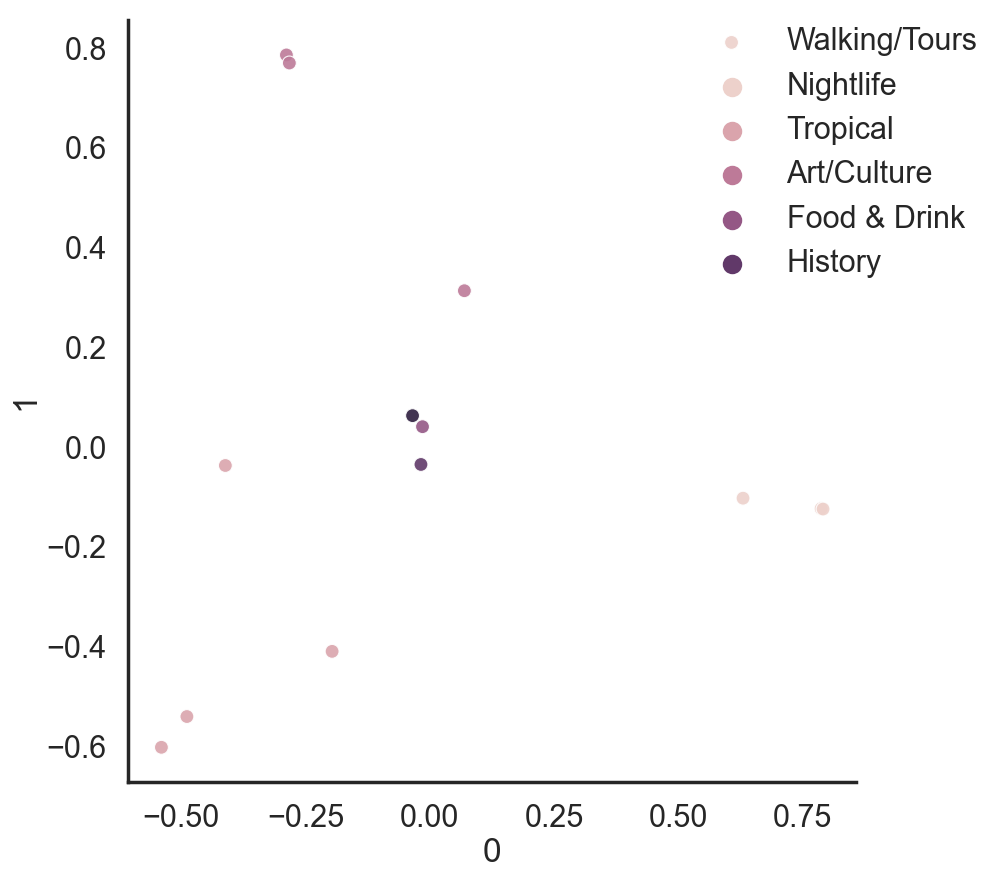

In [52]:
# Create scatter plots and highlight a couple of features
sns.set_style("white")
sns.set_context("poster")
six_topic_plot = sns.pairplot(x_vars=[0], y_vars=[1], data=pca_df, hue='Topics', markers='o', height=9, plot_kws=dict(s=100, alpha=0.9));
six_topic_plot._legend.remove()
six_topic_plot.fig.legend(labels=topic_list, frameon=False);     

six_topic_plot.savefig('topic.png')

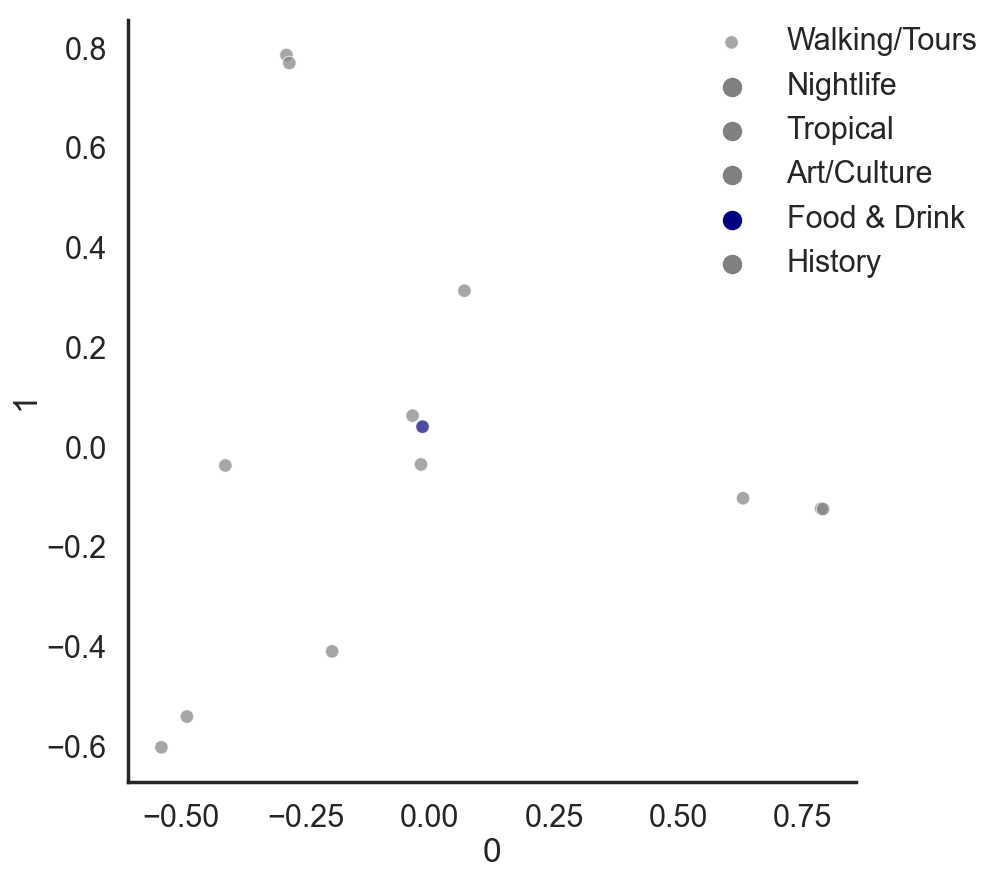

In [53]:
# Highlight art
sns.set_style("white")
sns.set_context("poster")
highlight_art = sns.pairplot(x_vars=[0], y_vars=[1], data=pca_df, hue='Topics', markers='o', palette=['grey','grey','grey','navy','grey','grey'], height=9, plot_kws=dict(s=95, alpha=0.7));
highlight_art._legend.remove()
highlight_art.fig.legend(labels=topic_list, frameon=False);

highlight_art.savefig('art.png')
  

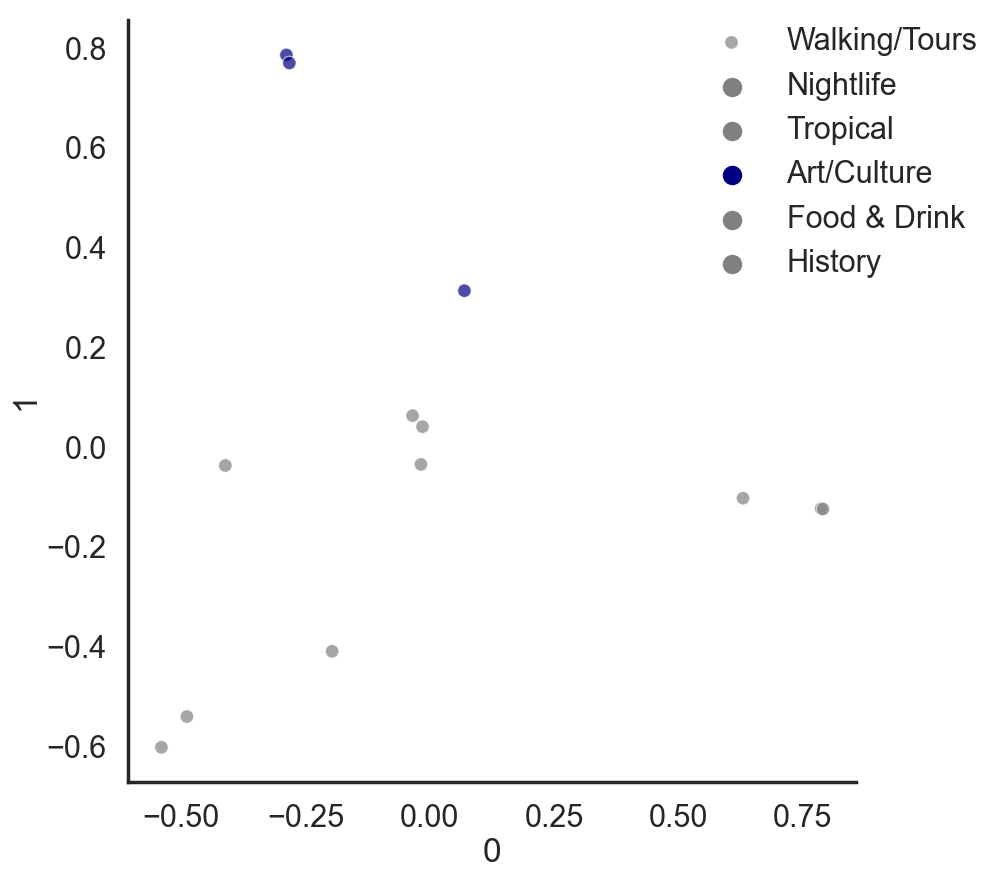

In [54]:
# Highlight Tropical
sns.set_style("white")
sns.set_context("poster")
highlight_trop = sns.pairplot(x_vars=[0], y_vars=[1], data=pca_df, hue='Topics', markers='o', palette=['grey','grey','navy','grey','grey','grey'], height=9, plot_kws=dict(s=95, alpha=0.7));
highlight_trop._legend.remove()
highlight_trop.fig.legend(labels=topic_list, frameon=False)

highlight_trop.savefig('trop.png');

## Recommender Engine

- Recommend based on topics - e.g. Rank which is most important & compare to topic distribution for each city

In [55]:
# Function to rank topics 
def rank(var_list):
    '''Takes a list of numbers and ranks them based on highest to lowest'''
    sorted_unique = sorted(set(var_list), reverse=True)
    order_dict = {val: i for i, val in enumerate(sorted_unique, 1)}
    return [order_dict[val] for val in var_list]

In [56]:
# Separate norm_df rows into lists
li = []
for i in range(0,len(norm_df)):
    df_list = list(norm_df.iloc[i])
    li.append(rank(df_list))   

In [59]:
# Create df with rankings of each topic for each country
ranked_df = pd.DataFrame(li, columns=topic_list, index=cities)
ranked_df.head()

In [ ]:
import pickle
ranked_df.to_pickle('ranked_df.pickle') 

In [65]:
# Test manually for flask app
walking_rank = int(input())
nightlife_rank = int(input())
tropical_rank = int(input())
art_rank = int(input())
fandd_rank = int(input())
history_rank = int(input())

In [66]:
inputs = {'Walking/Tours' : walking_rank, 
          'Nightlife':nightlife_rank, 
          'Tropical':tropical_rank, 
          'Art/Culture':art_rank, 
          'Food & Drink':fandd_rank, 
          'History':history_rank}

In [68]:
city_recommendations = recommendation(inputs)
correct_countries = return_countries(city_recommendations)
dict(zip(city_recommendations, correct_countries))

{'Boston': 'USA'}